<a href="https://colab.research.google.com/github/albertbolanoss/labs_deep_learning/blob/fruit-single-shot-detection/notebooks/fruit-single-shot-detection/01_training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Fruit single shot detector

## 0. Imports and global functions.

In [33]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import tensorflow as tf
import xml.etree.ElementTree as ET
from google.colab import auth
from googleapiclient.discovery import build
from google.colab import userdata

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Dropout, Reshape, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import tensorflow as tf

from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload
import io
import os

# Request permissions to access (read/write) the Google Drive Folder ID
GOOGLE_DRIVE_FOLDER_ID = "14LvaZfifLwoGsnIbwINaEZMSLEpP4E4-"
auth.authenticate_user()
drive_service = build('drive', 'v3')

# 1. Función para guardar en Google Drive
def save_model_to_drive(model_obj, filename):
    # Primero guardamos localmente
    local_path = f"/content/{filename}"
    model_obj.save(local_path)
    print(f"Modelo guardado localmente en {local_path}")

    # Metadatos para Drive
    file_metadata = {
        'name': filename,
        'parents': [GOOGLE_DRIVE_FOLDER_ID]
    }

    media = MediaFileUpload(local_path, mimetype='application/octet-stream')

    # Subir
    print("Subiendo a Google Drive...")
    file = drive_service.files().create(
        body=file_metadata,
        media_body=media,
        fields='id'
    ).execute()

    print(f"Modelo subido con ID: {file.get('id')}")


def load_model_from_drive(filename, folder_id, drive_service, custom_objects=None):
    """
    Descarga un modelo de una carpeta específica de Google Drive y lo carga en Keras.

    Args:
        filename (str): El nombre exacto del archivo .keras en Drive.
        folder_id (str): El ID de la carpeta en Google Drive donde está el archivo.
        drive_service: La instancia autenticada del servicio de Drive.
        custom_objects (dict): Diccionario para mapear funciones personalizadas (ej. robust_loss).

    Returns:
        model: El modelo de Keras cargado.
    """
    print(f"Buscando '{filename}' en la carpeta de Drive...")

    # 1. Buscar el ID del archivo por su nombre dentro de la carpeta
    query = f"name = '{filename}' and '{folder_id}' in parents and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    items = results.get('files', [])

    if not items:
        raise FileNotFoundError(f"No se encontró el archivo '{filename}' en la carpeta con ID {folder_id}.")

    # Tomamos el primer archivo que coincida (por si hay duplicados)
    file_id = items[0]['id']
    print(f"Archivo encontrado. ID: {file_id}. Descargando...")

    # 2. Descargar el archivo a un buffer o archivo temporal
    request = drive_service.files().get_media(fileId=file_id)

    # Ruta local temporal para guardar el modelo descargado
    local_path = f"/content/downloaded_{filename}"

    with io.FileIO(local_path, 'wb') as fh:
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while done is False:
            status, done = downloader.next_chunk()
            print(f"Descarga {int(status.progress() * 100)}%.")

    print("Descarga completa. Cargando modelo en memoria...")

    # 3. Cargar el modelo con Keras
    # IMPORTANTE: Pasamos custom_objects para que reconozca la loss function
    try:
        model = load_model(local_path, custom_objects=custom_objects)
        print("Modelo cargado exitosamente.")
        return model
    except Exception as e:
        print(f"Error al cargar el modelo con Keras: {e}")
        return None


class GoogleDriveCheckpoint(Callback):
    """
    Custom Callback to save Keras models directly to a specific Google Drive folder
    using the Google Drive API.
    """
    def __init__(self, drive_service, folder_id, monitor='val_loss', verbose=1, save_best_only=True):
        super(GoogleDriveCheckpoint, self).__init__()
        self.drive_service = drive_service
        self.folder_id = folder_id
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.best = float('inf') # Initialize best loss as infinity

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)

        if current is None:
            print(f"Warning: Can save best model only with {self.monitor} available, skipping.")
            return

        # Check if performance improved
        if self.save_best_only and current < self.best:
            if self.verbose > 0:
                print(f"\nEpoch {epoch+1}: {self.monitor} improved from {self.best:.4f} to {current:.4f}, saving model to Drive.")

            self.best = current
            self._save_and_upload(epoch, current)

        elif not self.save_best_only:
            # If not saving best only, save every epoch
            self._save_and_upload(epoch, current)

    def _save_and_upload(self, epoch, loss_value):
        # 1. Define filename
        filename = f"fruit_resnet_ep{epoch+1:02d}_loss{loss_value:.4f}.keras"
        local_path = f"/content/{filename}"

        # 2. Save locally first
        self.model.save(local_path)

        # 3. Upload to Google Drive
        try:
            file_metadata = {
                'name': filename,
                'parents': [self.folder_id]
            }

            media = MediaFileUpload(local_path, mimetype='application/octet-stream')

            file = self.drive_service.files().create(
                body=file_metadata,
                media_body=media,
                fields='id'
            ).execute()

            if self.verbose > 0:
                print(f"Cloud Backup: Model uploaded to Drive with ID: {file.get('id')}")

        except Exception as e:
            print(f"Error uploading checkpoint to Drive: {e}")

        finally:
            # 4. Cleanup local file to save space in Colab VM
            if os.path.exists(local_path):
                os.remove(local_path)

## 1. Download dataset.

In [25]:

KAGGLE_DATASET = "mbkinaci/fruit-images-for-object-detection"
BASE_DIR = "/content/fruit_data"
MODEL_TO_LOAD = "fruit_detector_v1.keras"
MODEL_TO_SAVE = "fruit_detector_v1.keras"

# Configurar Kaggle
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

# Descargar y descomprimir
if not os.path.exists(BASE_DIR):
    print("Download dataset...")
    !kaggle datasets download -d {KAGGLE_DATASET}
    !unzip -q fruit-images-for-object-detection.zip -d {BASE_DIR}
    print(f"Dataset download in {BASE_DIR}")
else:
    print("The dataset has been already downloaded.")

# Verificar estructura
print("Dataset Folders:", os.listdir(BASE_DIR))

The dataset has been already downloaded.
Dataset Folders: ['train_zip', 'test_zip']


## 3. Pre-processing
Regroup the dataset annotations so that each unique image is associated with all its bounding boxes and labels, eliminating the duplicate image entries found in the current variables. You should re-process the data from /content/fruit_data or restructure the existing arrays.

After grouping, implement a Target Encoder to map the variable-length ground truth boxes to a fixed-size grid tensor (e.g., 7x7). This encoder should assign objects to grid cells based on their center coordinates (similar to YOLO or simplified SSD), creating the target tensors required for training.

## 3.1 Encode features

In [34]:
# Parámetros
GRID_SIZE = 7
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

# Mapeo de Clases
CLASS_MAP = {"apple": 0, "banana": 1, "orange": 2}
INV_CLASS_MAP = {0: "apple", 1: "banana", 2: "orange"}

# Get image shape
def get_image_dimensions(img_path):
    try:
        img = cv2.imread(img_path)
        if img is not None:
            height, width, _ = img.shape
            return width, height
        else:
            print(f"Error: The image could not be loaded from the path: {img_path}")
            return None, None
    except Exception as e:
        print(f"Error trying to read the image: {img_path}: {e}")
        return None, None

# Load the datasets
def load_grouped_data(directory):
    images = []
    all_annotations = []

    # Iterate through all files in the directory
    for root_dir, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".xml"):
                xml_path = os.path.join(root_dir, file)

                # Parse XML
                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Get image path
                filename = root.find("filename").text
                img_path = os.path.join(root_dir, filename)

                if not os.path.exists(img_path):
                  print(f"Image not found: {img_path}")
                  continue

                # Get original dimensions
                size = root.find("size")
                # many of the xml files were setting with width=0, height=0
                # w_orig = int(size.find("width").text)
                # h_orig = int(size.find("height").text)
                w_orig, h_orig = get_image_dimensions(os.path.join(directory, filename))


                # Find all valid objects
                objects = root.findall("object")
                img_boxes = []

                for obj in objects:
                    name = obj.find("name").text
                    if name in CLASS_MAP:
                        label = CLASS_MAP[name]
                        bndbox = obj.find("bndbox")
                        xmin = int(bndbox.find("xmin").text)
                        ymin = int(bndbox.find("ymin").text)
                        xmax = int(bndbox.find("xmax").text)
                        ymax = int(bndbox.find("ymax").text)


                        # Store as [xmin_norm, ymin_norm, xmax_norm, ymax_norm, label] for now
                        # Actually, keeping min/max for flexibility or converting to center/size directly?
                        # The instructions say "Normalize the bounding box coordinates to [0, 1]"
                        # Let's store [xmin/w, ymin/h, xmax/w, ymax/h, label]
                        img_boxes.append([
                            xmin / w_orig, ymin / h_orig, xmax / w_orig, ymax / h_orig, label
                        ])

                if img_boxes:
                    # Load and resize image
                    try:
                        img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
                        img_arr = img_to_array(img) / 255.0
                        images.append(img_arr)
                        all_annotations.append(img_boxes)
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")

    return np.array(images, dtype="float32"), all_annotations


# 1. Cargar los datos (Tu código original)
print("Reloading Train Data...")
X_train, train_bboxes = load_grouped_data(os.path.join(BASE_DIR, "train_zip", "train"))

print("Reloading original Test Data (to be split)...")
X_test_full, test_bboxes_full = load_grouped_data(os.path.join(BASE_DIR, "test_zip", "test"))

# 2. Dividir el Test Set en Validation y Test
# Usamos un test_size=0.5 para dividirlo exactamente a la mitad
print("Splitting data into Validation and Test sets...")

X_val, X_test, val_bboxes, test_bboxes = train_test_split(
    X_test_full,
    test_bboxes_full,
    test_size=0.5,
    random_state=42, # Semilla fija para que siempre divida igual
    shuffle=True
)

print(f"Final Shapes:")
print(f" - Train: {X_train.shape}")
print(f" - Validation: {X_val.shape}")
print(f" - Test: {X_test.shape}")


Reloading Train Data...
Reloading original Test Data (to be split)...
Splitting data into Validation and Test sets...
Final Shapes:
 - Train: (240, 224, 224, 3)
 - Validation: (30, 224, 224, 3)
 - Test: (30, 224, 224, 3)


## 3.2 Encode labels


- Frame the image in a 7 x 7 grid
- Get the SSD/YOLO cordenates confidence, centerX, centerY, width , height, one hot encode of the class [apple, banana, orange]


**Tensor Population:**

    *   At the calculated `[row, col]` index, it fills the depth vector `[8]` with:

        *   **Index 0:** Confidence = `1.0` (Object Present).
        *   **Index 1-4:** Coordinates `[cx, cy, w, h]`.
        *   **Index 5-7:** One-hot encoded Class Label (e.g., `[1, 0, 0]` for Apple).


**Output Vector Structure:**

`[ Confidence, cx, cy, w, h, Class0, Class1, Class2 ]`


In [35]:
# Target Encoder for SSD/YOLO style grid
def encode_target(bboxes_list, grid_size=GRID_SIZE, num_classes=3):
    # Output: (7, 7, 8) -> [confidence, cx, cy, w, h, c0, c1, c2]
    target = np.zeros((grid_size, grid_size, 5 + num_classes))

    for box in bboxes_list:
        xmin, ymin, xmax, ymax, label = box

        # Calculate Center and Size (normalized global)
        cx = (xmin + xmax) / 2.0
        cy = (ymin + ymax) / 2.0
        w = xmax - xmin
        h = ymax - ymin

        # Determine grid cell
        col = int(cx * grid_size)
        row = int(cy * grid_size)

        # Boundary check
        col = min(col, grid_size - 1)
        row = min(row, grid_size - 1)

        # Populate tensor if empty (or overwrite)
        # We set confidence to 1
        if target[row, col, 0] == 0:
            target[row, col, 0] = 1.0
            target[row, col, 1:5] = [cx, cy, w, h]
            target[row, col, 5 + int(label)] = 1.0

    return target

y_train = np.array([encode_target(bboxes) for bboxes in train_bboxes])

# Crear y_val (NUEVO)
y_val = np.array([encode_target(bboxes) for bboxes in val_bboxes])

# Crear y_test (Actualizado con el conjunto reducido)
y_test = np.array([encode_target(bboxes) for bboxes in test_bboxes])

print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")


y_train shape: (240, 7, 7, 8)
y_val shape: (30, 7, 7, 8)
y_test shape: (30, 7, 7, 8)


## 3.3 Visualize pre-processed datasets

Visualizing index: 199 from Train dataset...


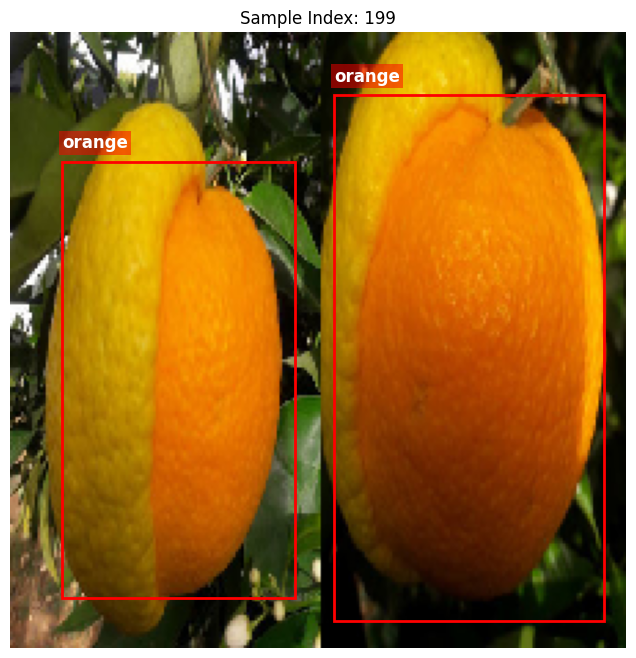

In [28]:
def visualize_dataset_sample(images, annotations, index):
    """
    Visualizes an image from the dataset with its corresponding bounding boxes and class labels.

    Args:
        images (numpy.array): The array of images (normalized 0-1).
        annotations (list): List of lists containing bounding boxes and labels.
                            Format: [[xmin, ymin, xmax, ymax, label], ...]
        index (int): The index of the image to visualize.
    """
    # 1. Retrieve image and annotations
    try:
        img = images[index]
        boxes = annotations[index]
    except IndexError:
        print(f"Error: Index {index} is out of bounds.")
        return

    # 2. Create plot
    fig, ax = plt.subplots(1, figsize=(8, 8))

    # Display the image
    # The input images are already normalized to [0, 1] based on your load_grouped_data function
    ax.imshow(img)

    # 3. Draw bounding boxes
    img_h, img_w, _ = img.shape

    if len(boxes) == 0:
        print("No objects labeled in this image.")

    for box in boxes:
        # Extract normalized coordinates and label
        # Your format: [xmin_norm, ymin_norm, xmax_norm, ymax_norm, label]
        xmin_n, ymin_n, xmax_n, ymax_n, label_idx = box

        # Denormalize coordinates to pixel values
        xmin = xmin_n * img_w
        ymin = ymin_n * img_h
        xmax = xmax_n * img_w
        ymax = ymax_n * img_h

        # Calculate width and height for the Rectangle patch
        width = xmax - xmin
        height = ymax - ymin

        # Get class name
        class_name = INV_CLASS_MAP.get(int(label_idx), "Unknown")

        # Create a Rectangle patch
        # (xy) is the bottom-left point usually, but in image coords (0,0 is top-left),
        # xy is the top-left corner of the rect.
        rect = patches.Rectangle(
            (xmin, ymin),
            width,
            height,
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )

        # Add the patch to the Axes
        ax.add_patch(rect)

        # 4. Add Label Text
        # We place a background box behind text for better readability
        plt.text(
            xmin,
            ymin - 5, # Slightly above the box
            class_name,
            color='white',
            fontsize=12,
            weight='bold',
            bbox=dict(facecolor='red', alpha=0.5, edgecolor='none', pad=2)
        )

    # Final cleanup
    plt.axis('off') # Hide axes ticks
    plt.title(f"Sample Index: {index}")
    plt.show()


# Select dataset to visualize (Change to X_test/test_bboxes if desired)
target_images = X_train
target_bboxes = train_bboxes

# Calculate a random index between 0 and the maximum index
random_index = random.randint(0, len(target_images) - 1)

print(f"Visualizing index: {random_index} from Train dataset...")

# Call the visualization function
visualize_dataset_sample(target_images, target_bboxes, random_index)

## 4. Data augmentations

In [29]:
import tensorflow as tf

def augment_data(image, label):
    """
    Applies random augmentations to the image and updates the label.
    """
    # 1. Photometric Augmentations
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.clip_by_value(image, 0.0, 1.0)

    # 2. Random Horizontal Flip
    # Generate a random scalar for decision
    if tf.random.uniform(()) > 0.5:
        # Flip the image
        image = tf.image.flip_left_right(image)

        # Flip the grid horizontally (swap columns)
        # label shape is (7, 7, 8)
        label = tf.reverse(label, axis=[1])

        # Update cx coordinate: new_cx = 1.0 - cx
        # We need to decompose the last dimension to access cx (index 1)
        # Tensor structure: [conf, cx, cy, w, h, class...]

        # Split channels
        channels = tf.split(label, num_or_size_splits=8, axis=-1)

        conf = channels[0]
        cx = channels[1]

        # Calculate new cx
        # We multiply by conf to ensure background cells (conf=0) remain 0 instead of becoming 1.0
        new_cx = (1.0 - cx) * conf

        # Update the cx channel
        channels[1] = new_cx

        # Reassemble
        label = tf.concat(channels, axis=-1)

    return image, label

# Create Training Dataset
print("Creating Training Dataset with Augmentation...")
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train))
train_dataset = train_dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Create Validation Dataset (No augmentation)
print("Creating Validation Dataset...")
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Verify
print("Train Dataset Spec:", train_dataset.element_spec)
print("Val Dataset Spec:", val_dataset.element_spec)

Creating Training Dataset with Augmentation...
Creating Validation Dataset...
Train Dataset Spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7, 7, 8), dtype=tf.float64, name=None))
Val Dataset Spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7, 7, 8), dtype=tf.float64, name=None))


## 4. Build the model

In [30]:
def build_resnet_yolo_model(input_shape=(224, 224, 3), grid_size=7, num_classes=3):
    # 1. Cargar el Backbone (ResNet50 pre-entrenada)
    # include_top=False elimina las capas de clasificación final de ImageNet
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Congelamos las capas base para no dañar los pesos pre-entrenados al inicio
    base_model.trainable = False

    # Obtenemos la salida de la base (Shape: 7, 7, 2048)
    x = base_model.output

    # 2. Detection Head (Cabezal de detección robusto)

    # Capa de reducción de características (2048 -> 512)
    # Usamos kernel 3x3 para aprender contexto espacial
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.3)(x) # Dropout ayuda a evitar sobreajuste

    # Capa intermedia para refinar (512 -> 256)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    # 3. Output Layer
    # Necesitamos predecir 8 valores por celda:
    # [Confianza, cx, cy, w, h, clase0, clase1, clase2]
    # Usamos 'sigmoid' porque tus coordenadas y clases están normalizadas entre 0 y 1
    output_filters = 5 + num_classes  # 8 filtros

    x = Conv2D(output_filters, (1, 1), padding='same', activation='sigmoid')(x)

    # Aseguramos que la salida tenga la forma (7, 7, 8)
    outputs = Reshape((grid_size, grid_size, output_filters))(x)

    # Crear el modelo final
    model = Model(inputs=base_model.input, outputs=outputs, name="ResNet50_Fruit_Detector")

    return model

# Instanciar modelo
model = build_resnet_yolo_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "ResNet50_Fruit_Detector"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 34,210,440 (130.50 MB)

 Trainable params: 10,621,192 (40.52 MB)

 Non-trainable params: 23,589,248 (89.99 MB)

## 5. Loss Function

In [31]:
def robust_loss(y_true, y_pred):
    """
    y_true/y_pred shape: (Batch, 7, 7, 8)
    Index map:
    0     : Confianza (Objectness)
    1-4   : cx, cy, w, h
    5-7   : Clases (One-hot)
    """

    # Máscara de objetos: 1 si hay fruta en la celda, 0 si es fondo
    # Extraemos el índice 0 (Confianza real)
    object_mask = y_true[..., 0:1]

    # --- 1. Coordinate Loss (Solo si hay objeto) ---
    # Penalizamos error en centro (cx, cy) y tamaño (w, h)
    # Multiplicamos por object_mask para ignorar celdas vacías
    coord_loss = object_mask * K.square(y_true[..., 1:5] - y_pred[..., 1:5])

    # --- 2. Class Loss (Solo si hay objeto) ---
    # Penalizamos error en clasificación
    class_loss = object_mask * K.square(y_true[..., 5:] - y_pred[..., 5:])

    # --- 3. Confidence Loss (Objectness) ---
    # Aquí es el truco: Queremos que aprenda que SI hay objeto (1) y que NO hay objeto (0)

    # Error cuando SI hay objeto
    conf_pos_loss = object_mask * K.square(y_true[..., 0:1] - y_pred[..., 0:1])

    # Error cuando NO hay objeto (Background)
    # Le damos menos peso (0.5) para que no domine, ya que hay mucho fondo
    conf_neg_loss = (1 - object_mask) * K.square(y_true[..., 0:1] - y_pred[..., 0:1])

    # --- Total Loss ---
    # Pesos lambda (Hiperparámetros tipo YOLO)
    lambda_coord = 5.0  # Dar prioridad a encontrar la caja exacta
    lambda_noobj = 0.5  # Bajar prioridad al fondo

    loss = K.sum(lambda_coord * coord_loss) + \
           K.sum(class_loss) + \
           K.sum(conf_pos_loss) + \
           K.sum(lambda_noobj * conf_neg_loss)

    return loss

## Trainning

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Instanciar el Custom Callback
drive_checkpoint = GoogleDriveCheckpoint(
    drive_service=drive_service,
    folder_id=GOOGLE_DRIVE_FOLDER_ID,
    monitor='val_loss',
    verbose=1,
    save_best_only=True # Solo guarda si el val_loss baja
)

# Callbacks estándar adicionales
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

# Compilar
optimizer = Adam(learning_rate=1e-4)
model.compile(loss=robust_loss, optimizer=optimizer)

print("Starting training with Google Drive API Checkpoints...")

# Entrenar
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[drive_checkpoint, early_stopping, reduce_lr], # Usamos nuestro callback personalizado
    shuffle=True
)


save_model_to_drive(model, MODEL_TO_SAVE)
print("Model saved and uploaded successfully.")


save_model_to_drive(model, MODEL_TO_SAVE)
print("Model saved and uploaded successfully.")

SyntaxError: invalid syntax. Perhaps you forgot a comma? (ipython-input-329363091.py, line 23)

## 7. Evaluate the model

Evaluando modelo...


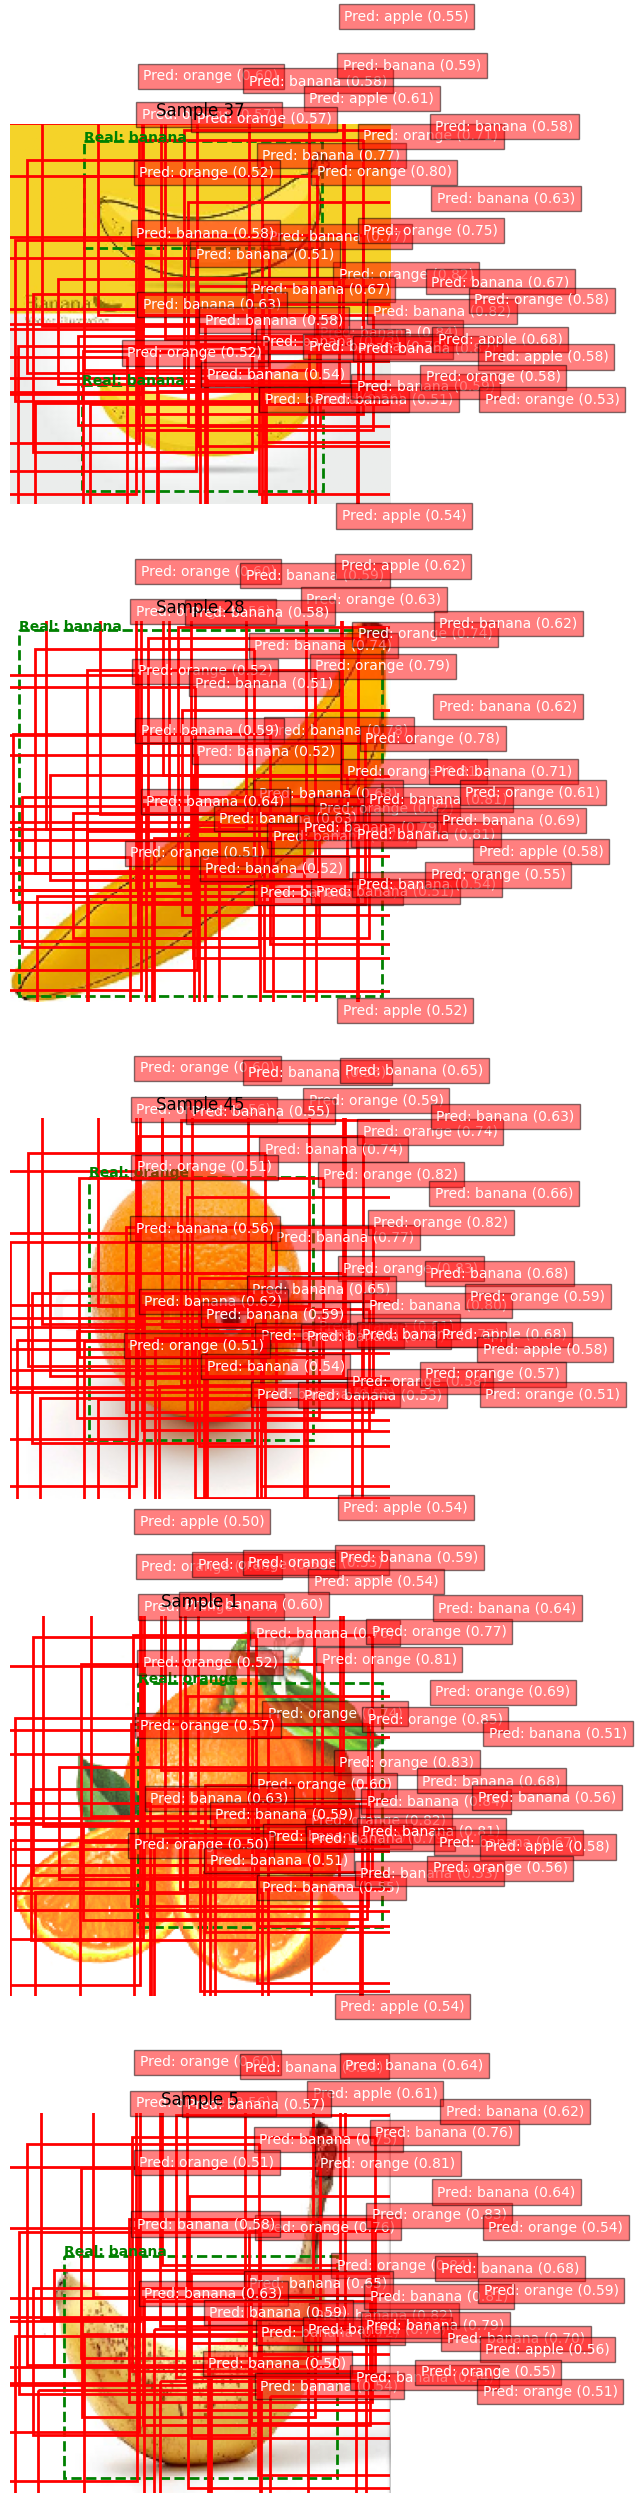


--- Average IoU on matched objects: 0.2259 ---


In [22]:
def decode_prediction(grid_tensor, grid_size=7, threshold=0.5):
    """
    Convierte la salida del modelo (7, 7, 8) a una lista de cajas [xmin, ymin, xmax, ymax, label, score]
    """
    boxes = []

    # Iterar sobre las celdas del grid
    for row in range(grid_size):
        for col in range(grid_size):
            cell = grid_tensor[row, col]
            confidence = cell[0]

            # Filtrar por umbral de confianza
            if confidence > threshold:
                # Recuperar datos
                cx_rel, cy_rel, w, h = cell[1:5]
                class_probs = cell[5:]
                label_idx = np.argmax(class_probs)

                # Convertir coordenadas relativas a celda -> coordenadas globales normalizadas (0-1)
                # cx_global = (col + cx_rel) / grid_size
                cx = (col + cx_rel) / grid_size
                cy = (row + cy_rel) / grid_size

                # Convertir centro/ancho a esquinas (min/max)
                xmin = cx - (w / 2)
                ymin = cy - (h / 2)
                xmax = cx + (w / 2)
                ymax = cy + (h / 2)

                boxes.append([xmin, ymin, xmax, ymax, label_idx, confidence])

    return boxes

def calculate_iou(box1, box2):
    """Calcula Intersection over Union entre dos cajas [xmin, ymin, xmax, ymax, ...]"""
    # Coordenadas de la intersección
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union = area1 + area2 - intersection

    return intersection / (union + 1e-6) # Evitar división por cero

# Función de Evaluación Visual y Métrica
def evaluate_model(model, X_test, y_test, num_samples=5):

    plt.figure(figsize=(15, 5 * num_samples))

    total_iou = 0
    count_obj = 0

    # Seleccionar índices aleatorios
    indices = np.random.choice(len(X_test), num_samples, replace=False)

    for i, idx in enumerate(indices):
        img = X_test[idx]
        target_grid = y_test[idx]

        # 1. Predecir
        # Expandir dims porque el modelo espera un batch (1, 224, 224, 3)
        input_img = np.expand_dims(img, axis=0)
        pred_grid = model.predict(input_img, verbose=0)[0]

        # 2. Decodificar (Target y Predicción)
        gt_boxes = decode_prediction(target_grid, threshold=0.99) # Target tiene confianza 1.0
        pred_boxes = decode_prediction(pred_grid, threshold=0.5)  # Predicción filtramos > 0.5

        # 3. Dibujar
        ax = plt.subplot(num_samples, 1, i + 1)
        ax.imshow(img)
        img_h, img_w, _ = img.shape

        # Dibujar Ground Truth (Verde)
        for box in gt_boxes:
            xmin, ymin, xmax, ymax, label, _ = box
            rect = patches.Rectangle(
                (xmin * img_w, ymin * img_h), (xmax-xmin)*img_w, (ymax-ymin)*img_h,
                linewidth=2, edgecolor='green', facecolor='none', linestyle='--'
            )
            ax.add_patch(rect)
            ax.text(xmin*img_w, ymin*img_h, f"Real: {INV_CLASS_MAP[label]}", color='green', weight='bold')

        # Dibujar Predicciones (Rojo) y calcular IoU simple
        for p_box in pred_boxes:
            xmin, ymin, xmax, ymax, label, score = p_box

            # Buscar la caja real más cercana para calcular IoU
            best_iou = 0
            for g_box in gt_boxes:
                iou = calculate_iou(p_box, g_box)
                if iou > best_iou: best_iou = iou

            if best_iou > 0:
                total_iou += best_iou
                count_obj += 1

            rect = patches.Rectangle(
                (xmin * img_w, ymin * img_h), (xmax-xmin)*img_w, (ymax-ymin)*img_h,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(xmax*img_w, ymin*img_h, f"Pred: {INV_CLASS_MAP[label]} ({score:.2f})",
                    color='white', bbox=dict(facecolor='red', alpha=0.5))

        ax.set_title(f"Sample {idx}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    if count_obj > 0:
        print(f"\n--- Average IoU on matched objects: {total_iou/count_obj:.4f} ---")
    else:
        print("\n--- No objects matched or detected ---")

# Ejecutar evaluación
print("Evaluando modelo...")
evaluate_model(model, X_test, y_test, num_samples=5)

## 8. Load the model

In [ ]:
loaded_model = load_model_from_drive(
    filename=MODEL_TO_SAVE,
    folder_id=GOOGLE_DRIVE_FOLDER_ID,
    drive_service=drive_service,
    custom_objects={'robust_loss': robust_loss}
)

# Verificar
if loaded_model:
    loaded_model.summary()